In [1]:
from mpi4py import MPI
from dolfinx import mesh
from dolfinx.fem import functionspace
from dolfinx import fem

import numpy as np
import ufl
from dolfinx import default_scalar_type

from dolfinx.fem.petsc import LinearProblem

import pyvista
import scipy.optimize as opt

from petsc4py import PETSc


In [2]:
# Create a mesh with quadrilaterals, 8 in x and 8 in y
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

In [3]:
# Function space of first order polynomials
V = functionspace(domain, ("Lagrange", 1))

In [4]:
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0]**2 + 2 * x[1]**2)

In [5]:
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

In [6]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [7]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [8]:
f = fem.Constant(domain, default_scalar_type(-6))

In [9]:
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [10]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

In [11]:
print(pyvista.global_theme.jupyter_backend)

trame


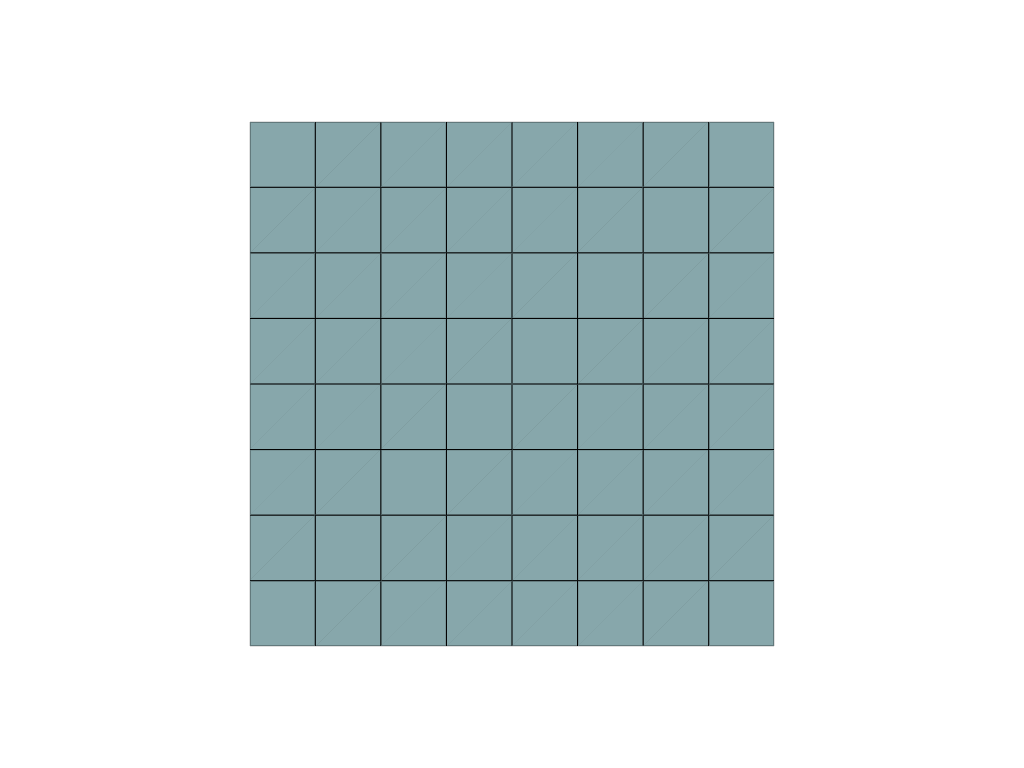

In [12]:
from dolfinx import plot

pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()

plotter.show()


# Tiaming Experiment 3

$$-\frac{d}{dx}(e^{k(x,\theta)}\frac{du(x)}{dx}) = 4x, \quad x\in (0,1),\theta \in [-1,1]$$
$$u(0) = 0, u(1)=2$$

where $k(x,\theta)$ has the following form:
 
$$  
k(x,\theta) =exp \left( \sum_{n=1}^{2} \sqrt a_{n} \theta_{n} b_{n}(x)  \right)
$$

where $a_{n} = \frac{8}{w_{n}^{2} + 16}$ and $b_{n} = A_{n}\left(  \text{sin}(w_{n}x) + \frac{w_{n}}{4} \text{cos}(w_{n}x) \right)$, $w_{n}$ is the $n_{th}$ solution of the equation $\text{tan} (w_{n}) = \frac{8w_{n}}{w_{n}^{2}-16}$ and $A_{n}$ is a constant of normalization which makes $\|b_{n}\| = 1$.

In [13]:
ns = 1
t= np.linspace(0,ns,1000)

w = np.linspace(-1,6,100)

def tang_eq(x):
    return (x**2 - 16)*np.tan(x) - 8*x

roots = []
for i in [(1,2),(2,3)]:
    roots.append(opt.bisect(tang_eq,i[0],i[1]))

print(roots)

theta, w = np.array([0.098, 0.430]),np.array(roots)

A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))

an = np.sqrt(8 / (w**2 + 16))

[1.5707963267941523, 2.153747972623023]


In [14]:
domain = mesh.create_unit_interval(MPI.COMM_WORLD, 30)

# Function space of first order polynomials
V = functionspace(domain, ("Lagrange", 1))

In [15]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

In [16]:
dofl = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0],0))

bc_l= fem.dirichletbc(PETSc.ScalarType(0), dofl, V)

dofr = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0],1))
bc_r = fem.dirichletbc(PETSc.ScalarType(2), dofr, V)

bcp = [bc_l, bc_r]

In [246]:
k = fem.Function(V)

k.interpolate(lambda x: np.exp(theta[0]*an[0]*A[0]*(np.sin(w[0]*x[0])+ ((w[0])/(4))*np.cos(w[0]*x[0])) \
              +theta[1]*an[1]*A[1]*(np.sin(w[1]*x[0])+ ((w[1])/(4))*np.cos(w[1]*x[0])))
              )

In [216]:
f = fem.Function(V)
f.interpolate(lambda x: 4*x[0])

In [217]:
a = k*ufl.dot(ufl.grad(u),  ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [218]:
problem = LinearProblem(a, L, bcs=bcp)
uh = problem.solve()

In [219]:
from scipy.integrate import solve_bvp

roots = np.array(roots)
def numerical_solution(theta_test,x_shock_test):

    def fun_shock(x, y):
        def k(x,theta = theta_test,w =roots):
            x = x.reshape(-1,1)

            A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
            
            bn =  A*(np.sin(w*x) + ((w)/(4))*np.cos(w*x))
            
            an = np.sqrt(8 / (w**2 + 16))

            return np.sum(an*bn*theta,axis=1)

        def dk(x,theta = theta_test,w =roots):
            x = x.reshape(-1,1)

            A = np.sqrt(1 / ( (1/8)*(5 + (w / 2)**2) +  (np.sin(2*w) / (4*w))*((w / 4)**2 - 1) - (np.cos(2*w)/8)))
            
            bn =  A*w*(np.cos(w*x)-((w)/(4))*np.sin(w*x))
            
            an = np.sqrt(8 / (w**2 + 16))

            return np.sum(an*bn*theta,axis=1)
            
        return np.vstack(( y[1], -(4*x*np.exp(-k(x)) + dk(x)*y[1]) ))

    def bc_shock(ya, yb):
        return np.array([ya[0], yb[0] - 2])

    x_shock = np.linspace(0, 1, 10)
    y_shock = np.zeros((2, x_shock.shape[0]))

    res_shock = solve_bvp(fun_shock, bc_shock, x_shock, y_shock, verbose=2)
    y_shock_plot = res_shock.sol(x_shock_test)

    return y_shock_plot[0].reshape(1,-1)

cells, types, x = plot.vtk_mesh(V)

x  = x[:,0].reshape(-1,1)
t = np.linspace(0,1,30).reshape(-1,1)

y_numerical = numerical_solution(theta,x)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.19e-04       6.94e-16          10              0       
Solved in 1 iterations, number of nodes 10. 
Maximum relative residual: 1.19e-04 
Maximum boundary residual: 6.94e-16


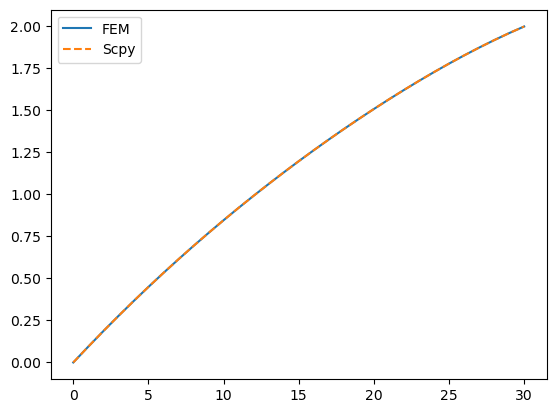

In [220]:
import matplotlib.pyplot as plt

plt.plot(uh.x.array, label = "FEM")
plt.plot(y_numerical[0], label = "Scpy",linestyle = "--")

plt.legend()

In [221]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx.fem.petsc import LinearProblem
from petsc4py import PETSc
import ufl
import scipy.optimize as opt
import matplotlib.pyplot as plt



In [ ]:
class Parametric_K:
    def __init__(self, theta, k_roots):
        """
        theta: List or array of theta values
        k_roots: List or array of roots
        """
        self.theta = np.array(theta)
        self.roots = np.array(k_roots)

    @property
    def A(self):
        """Compute the A coefficients for each root."""
        return np.sqrt(1 / ((1/8)*(5 + (self.roots / 2)**2) + 
                            (np.sin(2*self.roots) / (4*self.roots)) * ((self.roots / 4)**2 - 1) - (np.cos(2*self.roots)/8)))

    @property
    def an(self):
        """Compute the an values for each root."""
        return np.sqrt(8 / (self.roots**2 + 16))
    
    def eval(self, x):
        """
        Evaluate the sum for a given x, summing over all terms defined by theta and roots.
        x: 2D array of points (n, dim), where n is the number of points and dim is the dimension.
        Returns an array of evaluations for each point.
        """
        # Initialize the result array (same size as the number of points)
        result = np.zeros(x.shape[1])
        
        # Compute the sum over all terms
        for i in range(len(self.theta)):
            result += self.theta[i] * self.an[i] * self.A[i] * (
                np.sin(self.roots[i] * x[0]) + (self.roots[i] / 4) * np.cos(self.roots[i] * x[0])
            )
        return np.exp(result)

In [ ]:
theta = [0.098, 0.430, 0.430]
roots = [1.082, 2.478, 32.1]
k_function = Parametric_K(theta, roots)

# Create a Function in the function space
k = fem.Function(V)

# Interpolate the eval function of the Parametric_K class over the mesh
k.interpolate(k_function.eval)

The first 10 roots are: [ 1.57079633  2.15374797  4.57785946  4.71238898  7.28719433  7.85398163
 10.17397019 10.99557429 13.15666747 14.13716694]


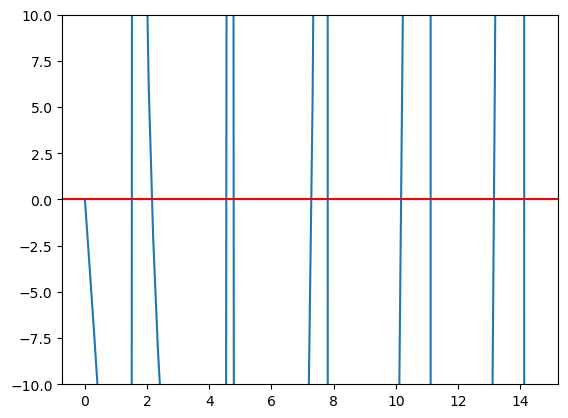

In [222]:

class RootFinder:
    def __init__(self, n, equation, intervals):
        """
        n: number of roots to find
        equation: the transcendental equation function
        intervals: list of tuples defining initial search intervals
        """
        self.n = n
        self.equation = equation
        self.intervals = intervals  # List of intervals where we expect roots
    
    def find_roots(self):
        """Find the first n roots using bisection method."""
        roots = []
        for interval in self.intervals:
            try:
                root = opt.bisect(self.equation, interval[0], interval[1])
                roots.append(root)
                if len(roots) == self.n:
                    break
            except ValueError as e:
                print(f"No root found in interval {interval}: {e}")
        return np.array(roots)
    
    def plot_equation(self,lext = 0, rext = 10, points = 100):
        x = np.linspace(self.intervals[0][0]-1,self.intervals[-1][-1],points)
        plt.plot(x, self.equation(x))
        plt.axhline(y = 0, color = 'r', linestyle = '-') 
        plt.ylim(-10,10)



def tang_eq(x):
    return (x**2 - 16)*np.tan(x) - 8*x

intervals = [(1,2),(2,3),(4,4.6),(4.7,4.8),(7.2,7.3),(7.3,8),(10,10.2),(10.2,11.5),(13,13.2),(14,14.5)]
n = 10

root_finder = RootFinder(n, tang_eq, intervals)
roots = root_finder.find_roots()
root_finder.plot_equation()
print(f"The first {n} roots are: {roots}")



In [260]:

# class Parametric_K:
#     def __init__(self, theta, k_roots, vert=30):
#         self.theta = theta
#         self.roots = k_roots

#     @property
#     def A(self):
#         """Compute the A coefficients."""
#         return np.sqrt(1 / ((1/8)*(5 + (self.roots / 2)**2) + 
#                             (np.sin(2*self.roots) / (4*self.roots)) * ((self.roots / 4)**2 - 1) - (np.cos(2*self.roots)/8)))
#     @property
#     def an(self):
#         """Compute the an values."""
#         return np.sqrt(8 / (self.roots**2 + 16))
    
#     def eval(self, x):
#         res = [th*a_*A_ *(np.sin(w*x[0]) + ((w)/(4)) * np.cos(w*x[0]))
#                 for th,a_,A_,w in zip(self.theta, self.an,self.A,self.roots)]
#         return np.exp(np.sum(res))
    
class Parametric_K:
    def __init__(self, theta, k_roots):
        self.theta = theta
        self.roots = k_roots

    @property
    def A(self):
        """Compute the A coefficients."""
        return np.sqrt(1 / ((1/8)*(5 + (self.roots / 2)**2) + 
                            (np.sin(2*self.roots) / (4*self.roots)) * ((self.roots / 4)**2 - 1) - (np.cos(2*self.roots)/8)))
    @property
    def an(self):
        """Compute the an values."""
        return np.sqrt(8 / (self.roots**2 + 16))
    
    def eval(self, x):
        res = np.exp(self.theta[0]*self.an[0]*self.A[0]*(np.sin(self.roots[0]*x[0])+ ((self.roots[0])/(4))*np.cos(self.roots[0]*x[0])) \
              +self.theta[1]*self.an[1]*self.A[1]*(np.sin(self.roots[1]*x[0])+ ((self.roots[1])/(4))*np.cos(self.roots[1]*x[0])))
                
        return res

In [261]:
class FEMSolver:
    def __init__(self, theta, k_roots, vert=30):
        self.theta = theta
        self.roots = k_roots
        self.domain = mesh.create_unit_interval(MPI.COMM_WORLD, vert)
        self.V = fem.functionspace(self.domain, ("Lagrange", 1))
        self.bc_l, self.bc_r = self.set_boundary_conditions()
        self.k = self.interpolate_k()
        self.f = self.interpolate_f()
    
    
    def interpolate_k(self):
        """Interpolate the k function based on the provided equation."""
        k = fem.Function(self.V)
        k_an = Parametric_K(self.theta,self.roots)
        k.interpolate(k_an.eval)
        return k


    def set_boundary_conditions(self):
        """Set the Dirichlet boundary conditions for the problem."""
        dofl = fem.locate_dofs_geometrical(self.V, lambda x: np.isclose(x[0], 0))
        bc_l = fem.dirichletbc(PETSc.ScalarType(0), dofl, self.V)

        dofr = fem.locate_dofs_geometrical(self.V, lambda x: np.isclose(x[0], 1))
        bc_r = fem.dirichletbc(PETSc.ScalarType(2), dofr, self.V)
        
        return bc_l, bc_r


    def interpolate_f(self):
        """Interpolate the f function."""
        f = fem.Function(self.V)
        f.interpolate(lambda x: 4 * x[0])
        return f

    def solve(self):
        """Define and solve the linear variational problem."""
        u = ufl.TrialFunction(self.V)
        v = ufl.TestFunction(self.V)

        # Define the bilinear form (a) and the linear form (L)
        a = self.k * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
        L = self.f * v * ufl.dx

        # Solve the linear problem
        problem = LinearProblem(a, L, bcs=[self.bc_l, self.bc_r])
        uh = problem.solve()
        return uh

# Example usage
if __name__ == "__main__":
    root_finder = RootFinder(2, tang_eq, intervals)
    roots = root_finder.find_roots()
    solver = FEMSolver(np.array([0.098, 0.430]),roots)
    solution = solver.solve()

    print("Solution obtained.")


Solution obtained.
